In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
from scipy.constants import speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9
ps = 1e-12

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI ** 2 / meV / c ** 2    

hbar = hbar_meV_ps
m = me
omega = 2 / hbar
vQD = 15

x0 = 0
x1 = 75
t0 = 0
t1 = 2
t2 = t1 + (x1 - x0) / vQD

x_min = -75
x_max = 150
t_min = t1
t_max = t2

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend for Apple GPU acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")
    print("Using CPU instead.")

Using cuda


In [4]:
class PINN(nn.Module):
    def __init__(self, layers, t_min, t_max):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        for units in layers[1:-1]:
            self.hidden_layers.append(nn.Linear(in_features=layers[0], out_features=units))
            layers[0] = units
        
        self.output_layer = nn.Linear(layers[-2], layers[-1])

        self.n_collocation = 5000
        self.n_initial = 500
        self.n_boundary = 500

        self.t_min = t_min
        self.t_max = t_max
    
    def forward(self, inputs):
        x, t = inputs
        X = torch.stack((x, t), dim=1)
        activation_1 = nn.Tanh()
        activation_2 = nn.SiLU()
        i = 1
    
        for layer in self.hidden_layers:
            X = layer(X)
            X = activation_1(X) if i < 2 else activation_2(X)
            i += 1
    
        output = self.output_layer(X)
        psi_real = output[:, 0]
        psi_img = output[:, 1]
        
        return psi_real, psi_img

In [5]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [6]:
model = PINN(layers, t_min, t_max)

In [7]:
model.load_state_dict(torch.load("../results/movement/model_1.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [8]:
import json

with open("../results/movement/history_1.json", "r") as f:
  history = json.load(f)

epochs = 150000

In [9]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

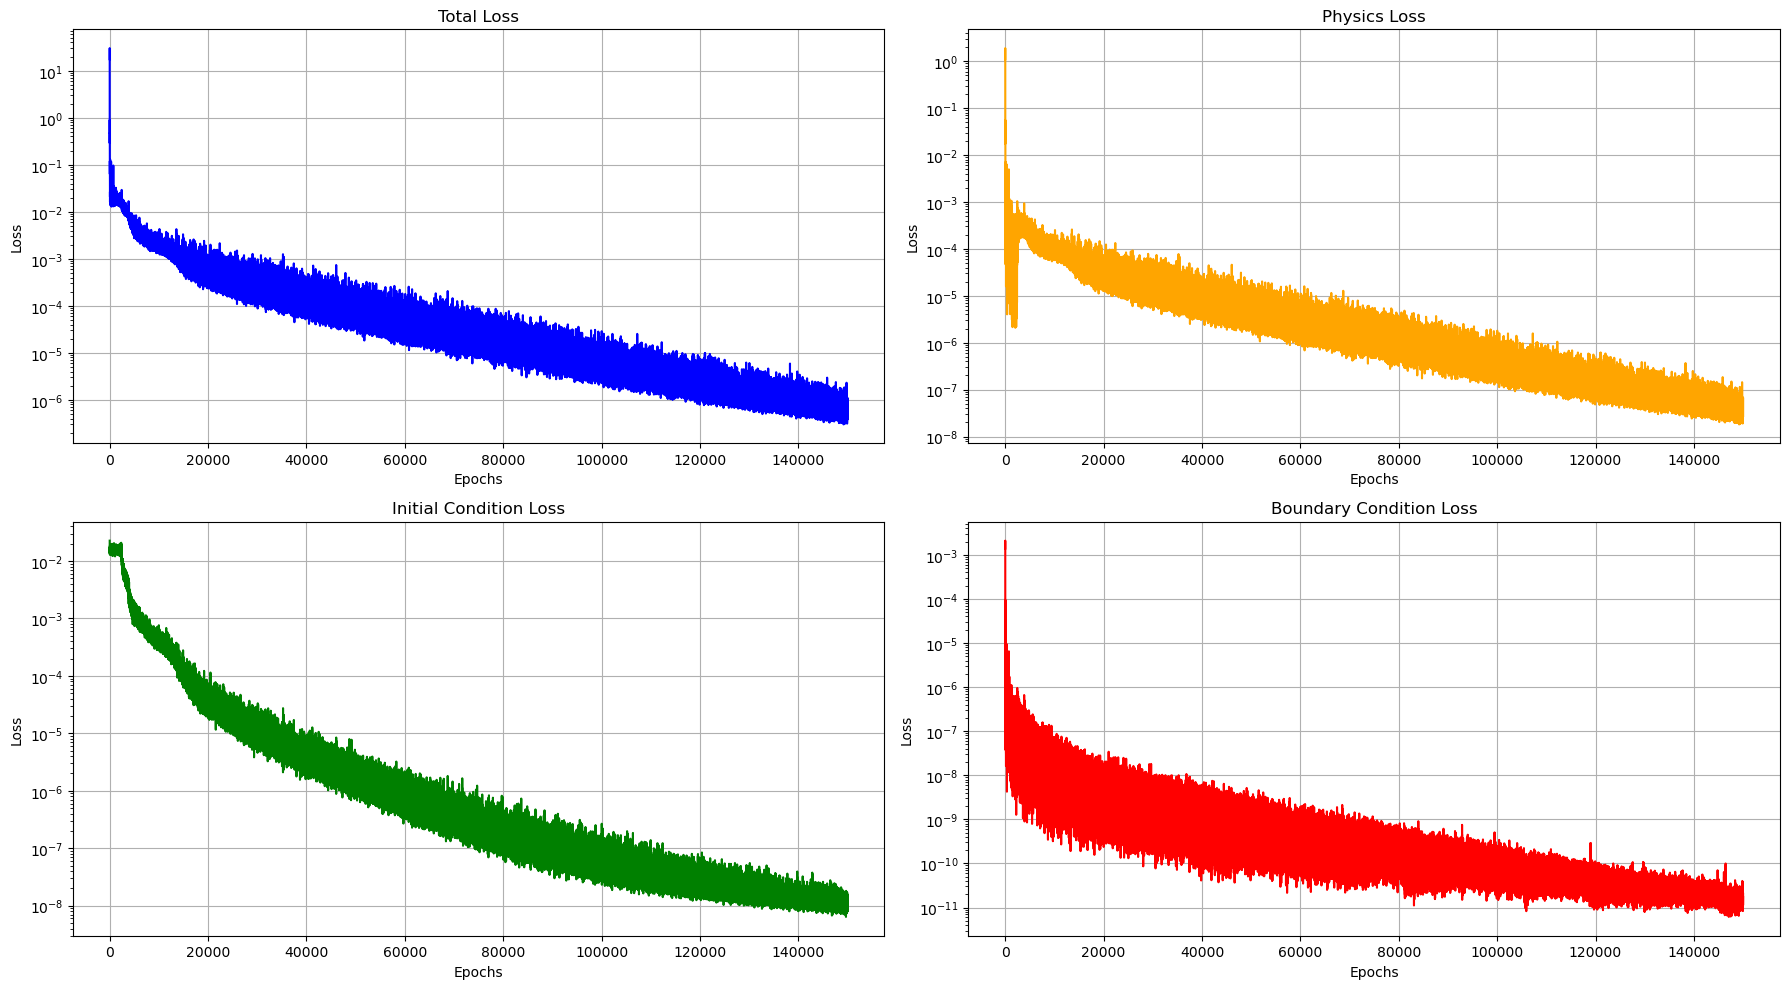

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

In [11]:
def view_metrics(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    mn = np.min(arr)
    mx = np.max(arr)
    
    fig = go.Figure(data=[go.Table(header=dict(values=['Mean', 'Standard Deviation', 'Min', 'Max']),
                 cells=dict(values=[[f"{mean:.5f}"], [f"{std:.5f}"], [f"{mn:.5f}"], [f"{mx:.5f}"]]))
                     ])
    fig.update_layout(width=500, height=300)
    fig.show()

In [12]:
Nx = 2000
Nt = 2000

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [13]:
x_values_torch = torch.from_numpy(x_values).float()
t_values_torch = torch.from_numpy(t_values).float()

x_grid, t_grid = torch.meshgrid(x_values_torch, t_values_torch, indexing="ij")

x_flat = torch.reshape(x_grid, [-1])
t_flat = torch.reshape(t_grid, [-1])

batch_size = 1000000
psi_real_list = []
psi_img_list = []

model.eval()
with torch.no_grad():
    for i in range(0, x_flat.shape[0], batch_size):
        x_batch = x_flat[i:i+batch_size]
        t_batch = t_flat[i:i+batch_size]
        psi_real, psi_img = model((x_batch, t_batch))
        psi_real_list.append(psi_real.cpu())
        psi_img_list.append(psi_img.cpu())

# psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

# psi_real_pinn = torch.reshape(psi_real_pinn, (Nx, Nt))
# psi_img_pinn = torch.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = torch.cat(psi_real_list).reshape(Nx, Nt).numpy()
psi_img_pinn = torch.cat(psi_img_list).reshape(Nx, Nt).numpy()

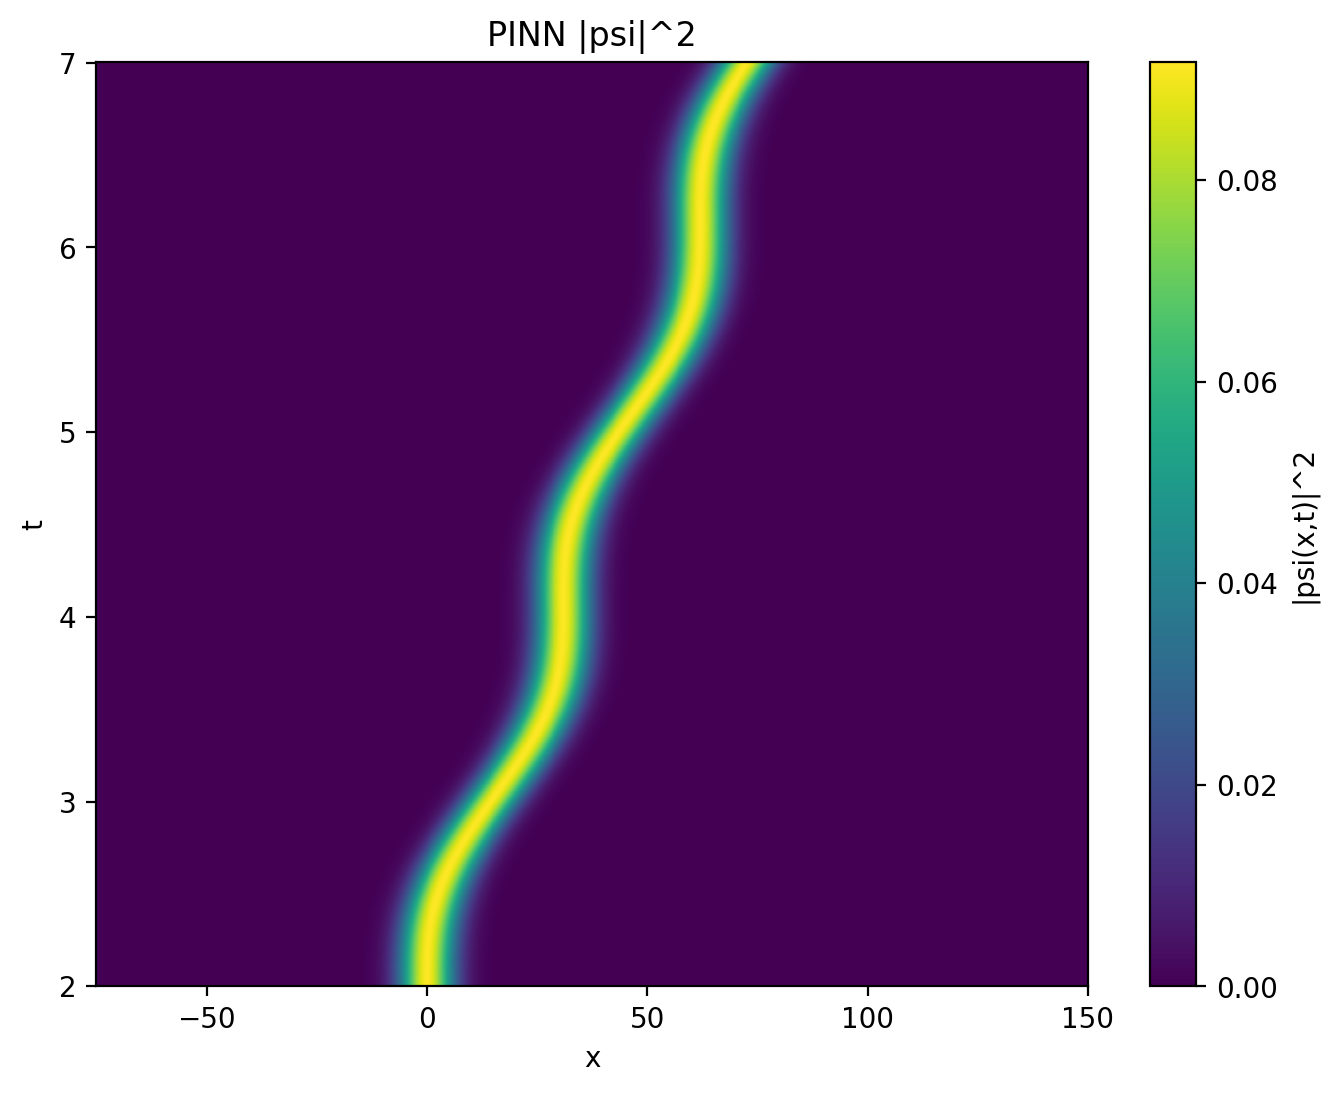

In [14]:
plt.figure(figsize=(8, 6), dpi=200)
psi_sq = psi_real_pinn ** 2 + psi_img_pinn ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')	
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN |psi|^2')
plt.show()

In [15]:
analytical_weights = np.load("../results/analytical/movement/crank_movement_weights.npz")

In [16]:
psi_sq_analytical = analytical_weights["psi_sq_analytical"]

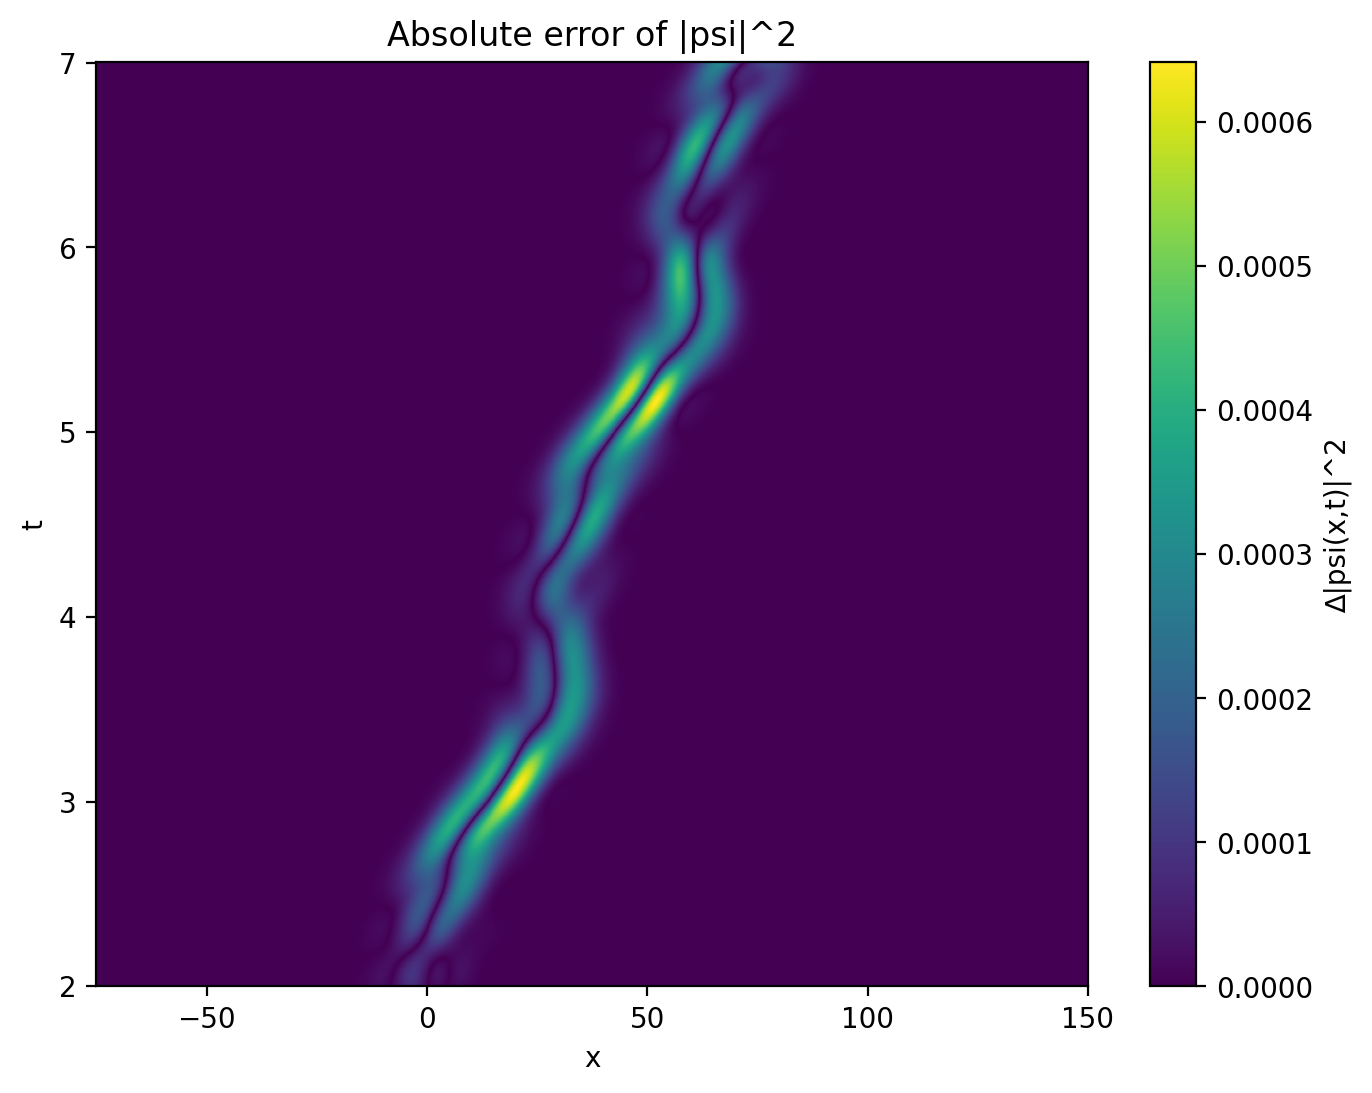

In [17]:
plt.figure(figsize=(8, 6), dpi=200)
psi_sq_diff = np.abs(psi_sq - psi_sq_analytical)
view_metrics(psi_sq_diff)

plt.pcolormesh(x_values, t_values, psi_sq_diff.transpose(), shading="auto")
plt.colorbar(label='∆|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute error of |psi|^2')
plt.show()

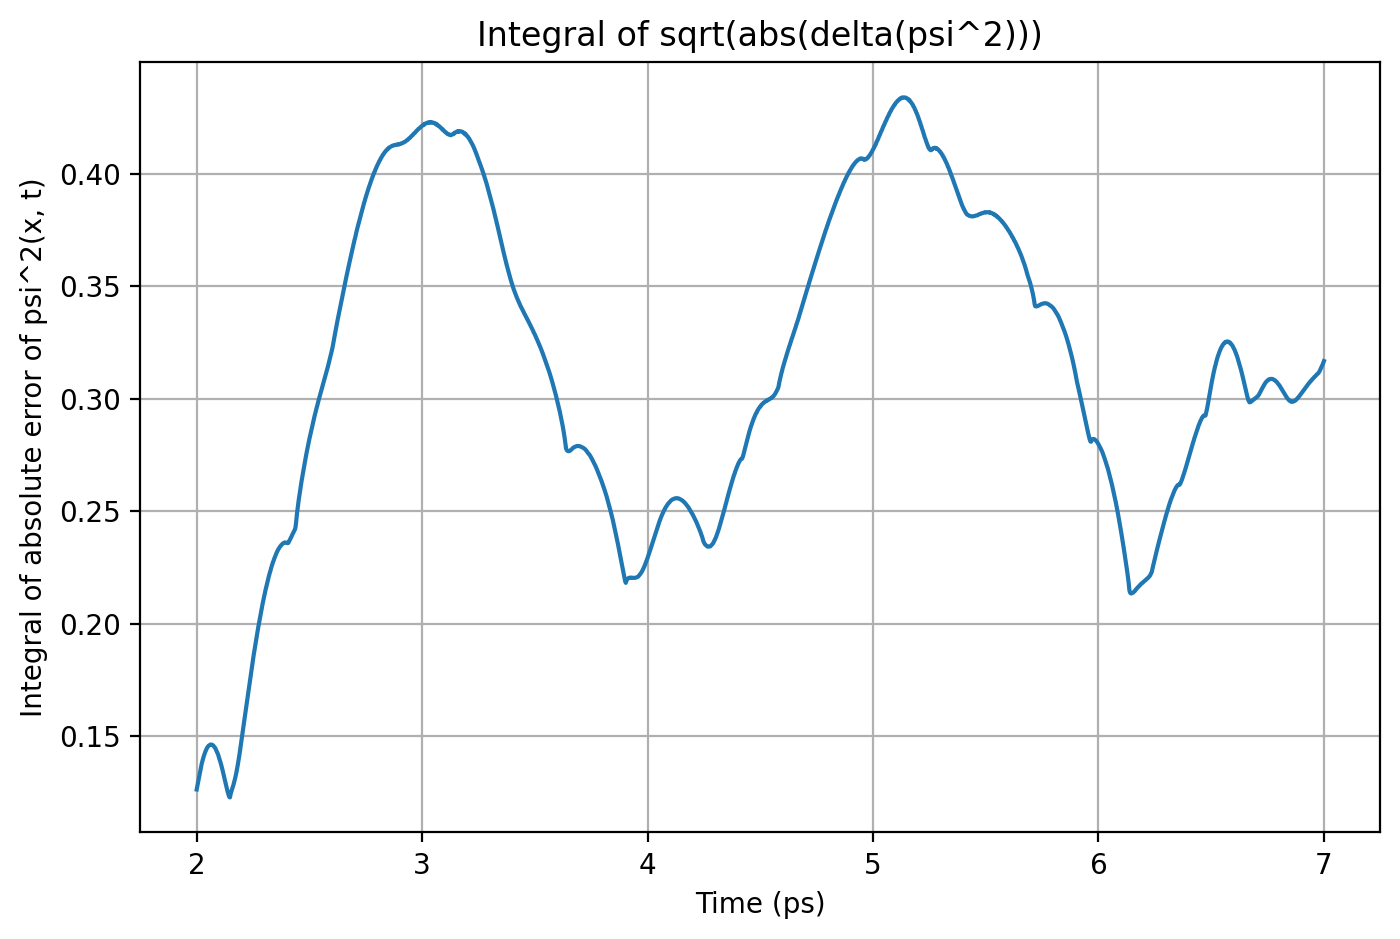

In [18]:
diff_integrals = np.sqrt(psi_sq_diff).mean(axis=0) * (x_max - x_min)
view_metrics(diff_integrals)

plt.figure(figsize=(8,5), dpi=200)
plt.plot(t_values, diff_integrals, '-')
plt.xlabel('Time (ps)')
plt.ylabel('Integral of absolute error of psi^2(x, t)')
plt.title('Integral of sqrt(abs(delta(psi^2)))')
plt.grid(True)
plt.show()

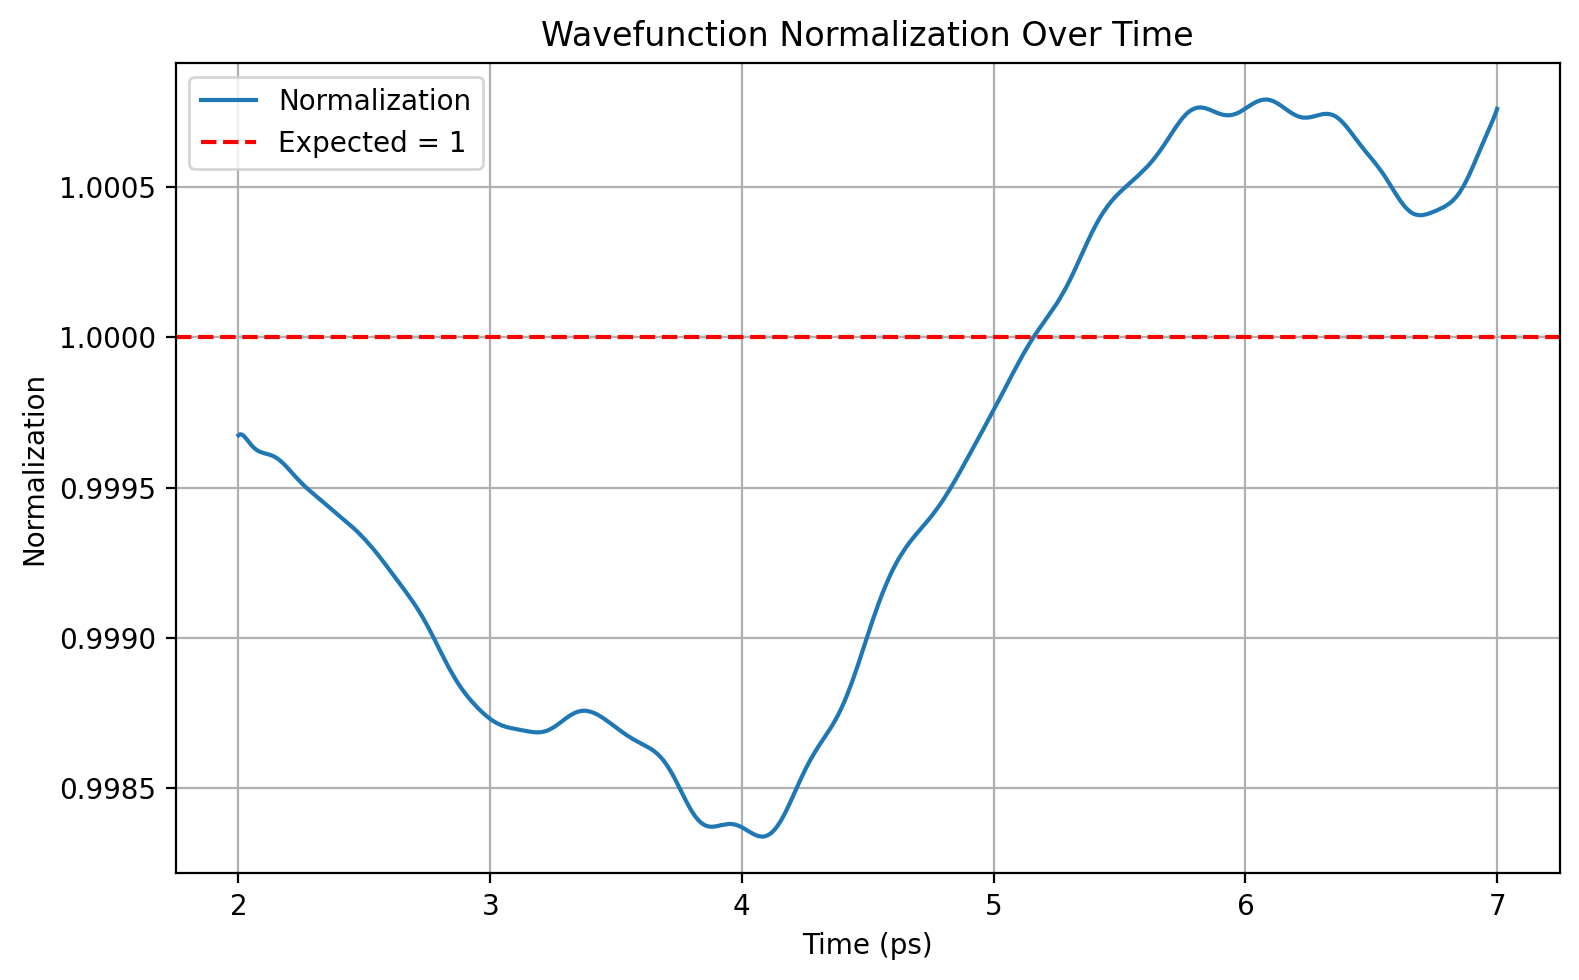

In [19]:
from scipy.integrate import simpson

norms = []

for i in range(2000):
    psi_sq_i = psi_real_pinn[:, i] ** 2 + psi_img_pinn[:, i] ** 2
    normalization = simpson(psi_sq_i, x=x_values)
    normalization_monte = np.mean(psi_sq_i) * (x_max - x_min)
    norms.append(normalization)
    
view_metrics(np.array(norms))

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)

ax.plot(t_values, norms, '-', label='Normalization')
ax.axhline(1.0, color='red', linestyle='--', label='Expected = 1')

# 🛠 Disable offset notation and scientific formatting
ax.yaxis.get_major_formatter().set_useOffset(False)

ax.set_xlabel('Time (ps)')
ax.set_ylabel('Normalization')
ax.set_title('Wavefunction Normalization Over Time')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

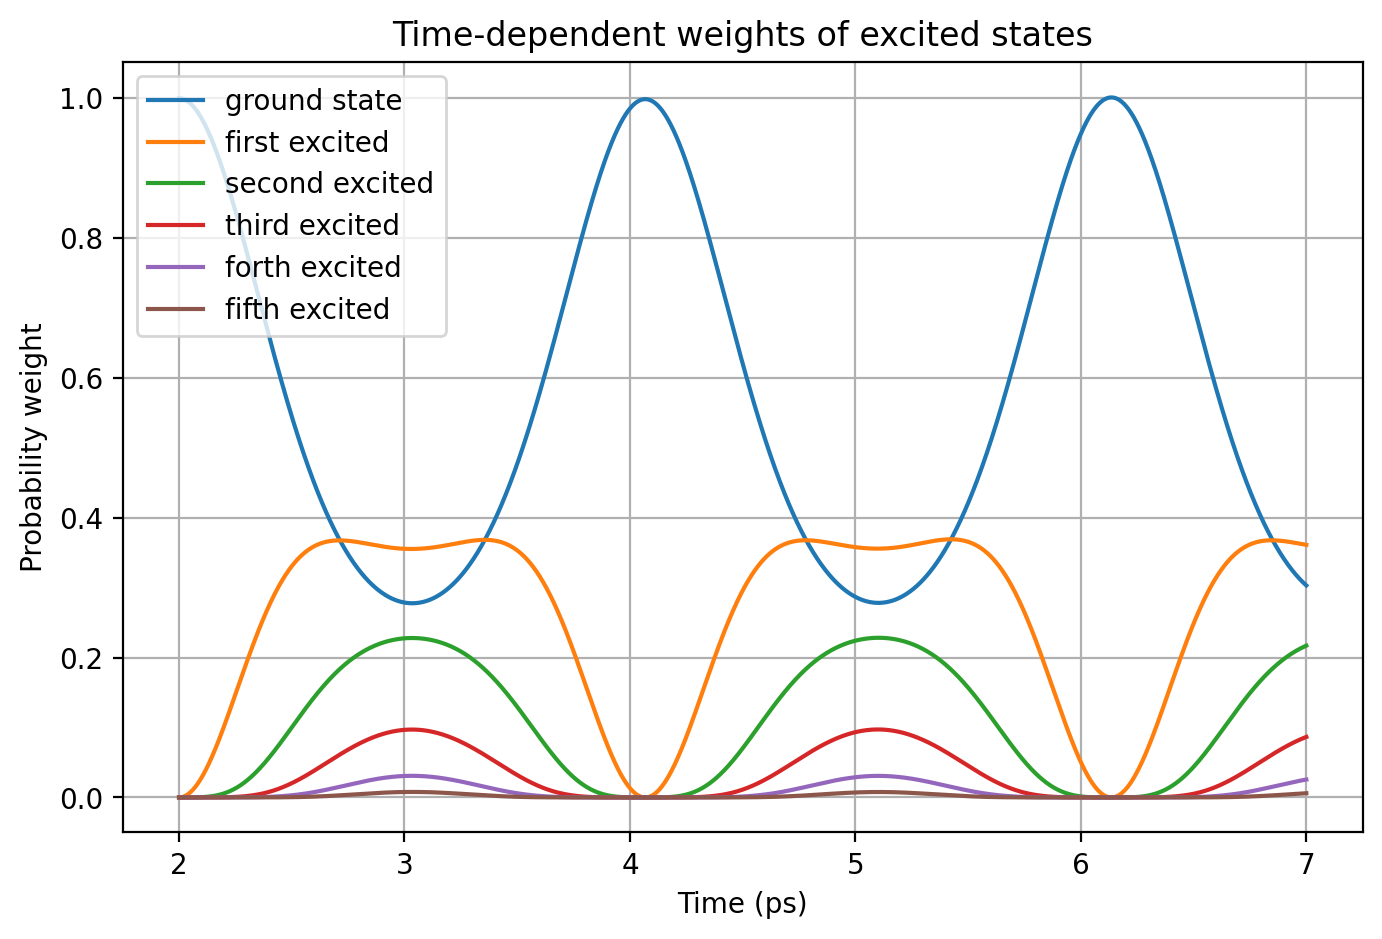

In [20]:
from scipy import special

psi_pinn = psi_real_pinn + 1j * psi_img_pinn

def quantum_center(t):
    if t < t1:
        return x0
    elif t < t1 + (x1 - x0) / vQD:
        return x0 + vQD * (t - t1)
    else:
        return x1
    
def psi_x_n(x, t, n):
    A = 1 / np.sqrt((2 ** n) * special.factorial(n))
    B = ((m * omega) / (np.pi * hbar)) ** (1/4)
    C = np.exp((-m * omega * (x - quantum_center(t)) ** 2) / (2 * hbar))
    D = special.eval_hermite(n, np.sqrt((m * omega) / hbar) * (x - quantum_center(t)))
    return A * B * C * D

def psi_x_t_n(x, t, n):
    A = psi_x_n(x, t, n)
    En = (n + (1/2)) * hbar * omega
    B = np.exp(-(1j * En * t) / hbar)
    return A * B

lambda0, lambda1 = [], []
lambda2, lambda3 = [], []
lambda4, lambda5 = [], []

for i, t in enumerate(t_values):
    psi = psi_pinn[:, i]
    
    psi0_t = psi_x_t_n(x_values, t, 0)
    psi1_t = psi_x_t_n(x_values, t, 1)
    psi2_t = psi_x_t_n(x_values, t, 2)
    psi3_t = psi_x_t_n(x_values, t, 3)
    psi4_t = psi_x_t_n(x_values, t, 4)
    psi5_t = psi_x_t_n(x_values, t, 5)
    
    lambda0_i = simpson(psi * np.conj(psi0_t), x=x_values)
    lambda1_i = simpson(psi * np.conj(psi1_t), x=x_values)
    lambda2_i = simpson(psi * np.conj(psi2_t), x=x_values)
    lambda3_i = simpson(psi * np.conj(psi3_t), x=x_values)
    lambda4_i = simpson(psi * np.conj(psi4_t), x=x_values)
    lambda5_i = simpson(psi * np.conj(psi5_t), x=x_values)
    
    lambda0.append(np.abs(lambda0_i) ** 2)
    lambda1.append(np.abs(lambda1_i) ** 2)
    lambda2.append(np.abs(lambda2_i) ** 2)
    lambda3.append(np.abs(lambda3_i) ** 2)
    lambda4.append(np.abs(lambda4_i) ** 2)
    lambda5.append(np.abs(lambda5_i) ** 2)

plt.figure(figsize=(8,5), dpi=200)
plt.plot(t_values, lambda0, label='ground state')
plt.plot(t_values, lambda1, label='first excited')
plt.plot(t_values, lambda2, label='second excited')
plt.plot(t_values, lambda3, label='third excited')
plt.plot(t_values, lambda4, label='forth excited')
plt.plot(t_values, lambda5, label='fifth excited')
plt.xlabel("Time (ps)")
plt.ylabel("Probability weight")
plt.title("Time-dependent weights of excited states")
plt.legend()
plt.grid(True)
plt.show()


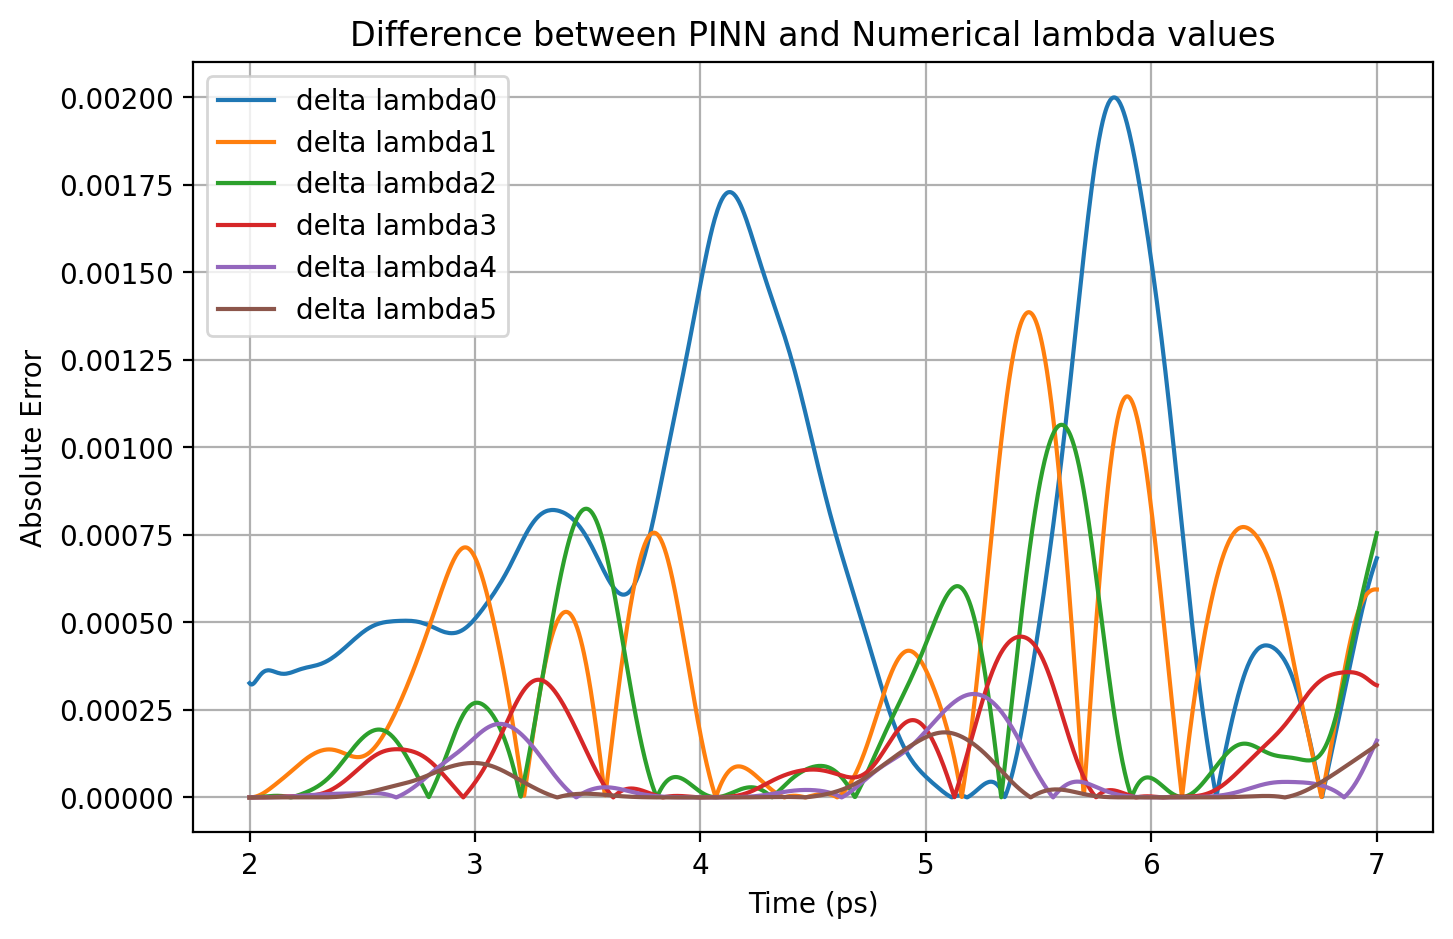

In [21]:
lambda0_analytical = analytical_weights["lambda0_analytical"]
lambda1_analytical = analytical_weights["lambda1_analytical"]
lambda2_analytical = analytical_weights["lambda2_analytical"]
lambda3_analytical = analytical_weights["lambda3_analytical"]
lambda4_analytical = analytical_weights["lambda4_analytical"]
lambda5_analytical = analytical_weights["lambda5_analytical"]

lambda0_diff = np.abs(lambda0 - lambda0_analytical)
lambda1_diff = np.abs(lambda1 - lambda1_analytical)
lambda2_diff = np.abs(lambda2 - lambda2_analytical)
lambda3_diff = np.abs(lambda3 - lambda3_analytical)
lambda4_diff = np.abs(lambda4 - lambda4_analytical)
lambda5_diff = np.abs(lambda5 - lambda5_analytical)

view_metrics(lambda0_diff)
view_metrics(lambda1_diff)
view_metrics(lambda2_diff)
view_metrics(lambda3_diff)
view_metrics(lambda4_diff)
view_metrics(lambda5_diff)

plt.figure(figsize=(8, 5), dpi=200)
plt.plot(t_values, lambda0_diff, label='delta lambda0')
plt.plot(t_values, lambda1_diff, label='delta lambda1')
plt.plot(t_values, lambda2_diff, label='delta lambda2')
plt.plot(t_values, lambda3_diff, label='delta lambda3')
plt.plot(t_values, lambda4_diff, label='delta lambda4')
plt.plot(t_values, lambda5_diff, label='delta lambda5')
plt.xlabel("Time (ps)")
plt.ylabel("Absolute Error")
plt.title("Difference between PINN and Numerical lambda values")
plt.grid(True)
plt.legend()
plt.show()
